In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product, cycle

In [2]:
def calculate_error(L, omega, V, V_, beta, T, dt, re_cutoff, img_cutoff, tolerance):
    ### BUILDING THE HAMILTONIAN
    
    dims = [2]*L # overall space of L qbits

    I = qu.pauli('I')
    X = qu.pauli('X')
    Z = qu.pauli('Z')
    # fisrt I build the operators
    nn_op = (I + Z)/2 & (I + Z)/2

    print(f'Building Hamiltonian for L={L}')
    # the hamiltonian
    H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
    H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
    H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

    H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

    # diagonalization
    e, U = la.eig(H, isherm=True)

    #print('done :)')
    
    ### BUILDING THE OBSERVABLES

    observables_ex = {}
    results_ex = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_ex[key] = []
        observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

    # dropping the identity
    observables_ex.pop('I1I2')
    results_ex.pop('I1I2')


    ### INITIAL CONDITIONS
    print('Initial state: random subsystem and thermal bath\n')

    #rho = la.expm(-beta*H)
    #rho /= rho.trace()

    rho = qu.gen.states.thermal_state(H, beta)

    # apply a random operator to the first two spins
    rand1 = qu.gen.rand.rand_uni(2)
    rand2 = qu.gen.rand.rand_uni(2)
    U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
    rho = U_rand @ rho @ U_rand.H

    ### THE SIMULATION

    # smarter way to calculate the coherence vector:
    rho_tilde = np.conj(U.T) @ rho @ U    

    pauli_tilde = {}
    t = []
    for key in observables_ex.keys():
        pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U

    for i in range(0, int(T/dt)):
        ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)

        trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
        for key in results_ex.keys():
            results_ex[key].append(trace(key))

        t.append( dt*i )

    #print("finished Time = %s" % T)

    print('done')
    
    ### BUILDING THE HAMILTONIAN for the thermalization

    O_Rabi = (omega/2)*X & I
    N = (I + Z)/2 & I

    print(f'Building Hamiltonian for L={L} \n')
    # the hamiltonian
    H1 = {i: O_Rabi for i in range(L)}
    H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

    H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

    ### BUILDING THE SPIN CHAIN

    print('Building the spin chain \n')
    B = np.array([1, 0, 0, 1])/np.sqrt(2)
    arrays = [B for i in range(L)]

    psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

    #psi.show()
    
    ### IMAGINARY TIME EVOLUTION

    print('Imaginary time evolution \n')

    # create the object
    tebd_th = qtn.TEBD(psi, H, imag=True)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd_th.split_opts['cutoff'] = img_cutoff

    tebd_th.update_to(beta/2, tol=tolerance)
    psi_th = tebd_th.pt / tebd_th.pt.norm()
    
    ### INITIAL CONDITIONS

    # random initial conditions
    Rand1 = rand1 & qu.pauli('I')
    Rand2 = rand2 & qu.pauli('I')

    psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')

    ### THE SIMULATION
    
    print('Real time evolution')
    start = time.time()

    # first I build the observables
    observables_tebd = {}
    results_tebd = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_tebd[key] = []
        observables_tebd[key] = []

    # dropping the identity
    observables_tebd.pop('I1I2')
    results_tebd.pop('I1I2')

    # create the object
    tebd = qtn.TEBD(psi_init, H)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd.split_opts['cutoff'] = re_cutoff

    keys = results_tebd.keys()

    # I can either set a timestep or a tolerance and the timestep is calculated accordingly
    # generate the state at each time in t (same as exact simulation)
    #     and target error 1e-3 for whole evolution
    for psit in tebd.at_times(t, tol=tolerance):
        for key in keys:
            ob1 = qu.pauli(key[0]) & qu.pauli('I')
            ob2 = qu.pauli(key[2]) & qu.pauli('I')
            results_tebd[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)

    end = time.time()
    print(f'Time:{int(end - start)}s')
    
    ### PLOT & MAX ERROR

    line_styles = ['-', '-', '-', '-', ':', '--', '--', '-', '--', ':', '--', '-', '--', '--', ':']
    stylescicler = cycle(line_styles)
    line_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:blue', 'tab:orange', \
                   'tab:purple', 'tab:green', 'tab:orange', 'tab:red', 'tab:pink', 'tab:purple', 'tab:pink',\
                   'tab:green']
    colorscicler = cycle(line_colors)

    keys = observables_tebd.keys()

    diff = {}

    plt.figure(dpi=130)

    norm = []
    for i in range(len(t)):
        norm.append(np.linalg.norm(np.array([results_ex[key][i] for key in keys])))
        
    max_err = 0
    for key in keys:
        diff[key] = [abs(results_ex[key][i] - results_tebd[key][i])/norm[i] for i in range(len(t))]
        max_err = max(max_err, max(diff[key]))
        plt.plot(t, diff[key], linewidth=1, label=key, linestyle=next(stylescicler), color=next(colorscicler))

    plt.grid()
    plt.xlabel(r't/$\Omega$')
    plt.title('Exact - TEBD')

    fig = plt.gcf()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return max_err

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5e-05, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7957.32%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:56<00:00, 17.72it/s]


Time:56s


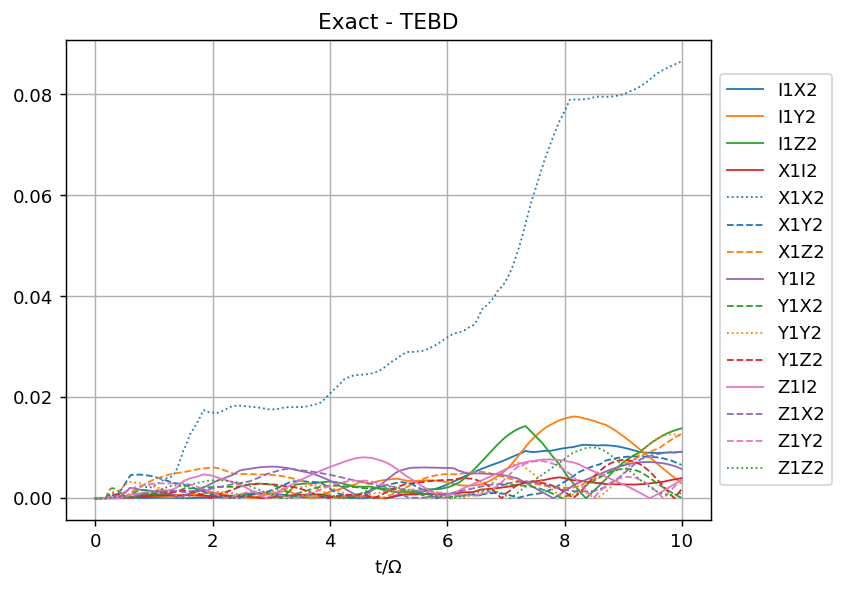

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5e-05, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4862.00%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:41<00:00, 24.10it/s]


Time:41s


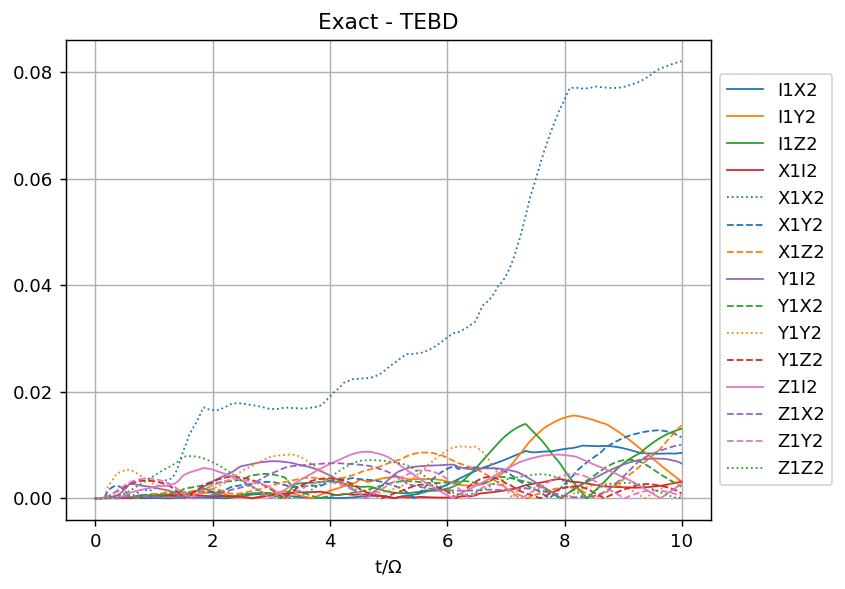

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5e-05, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8069.54%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:48<00:00, 20.70it/s]


Time:48s


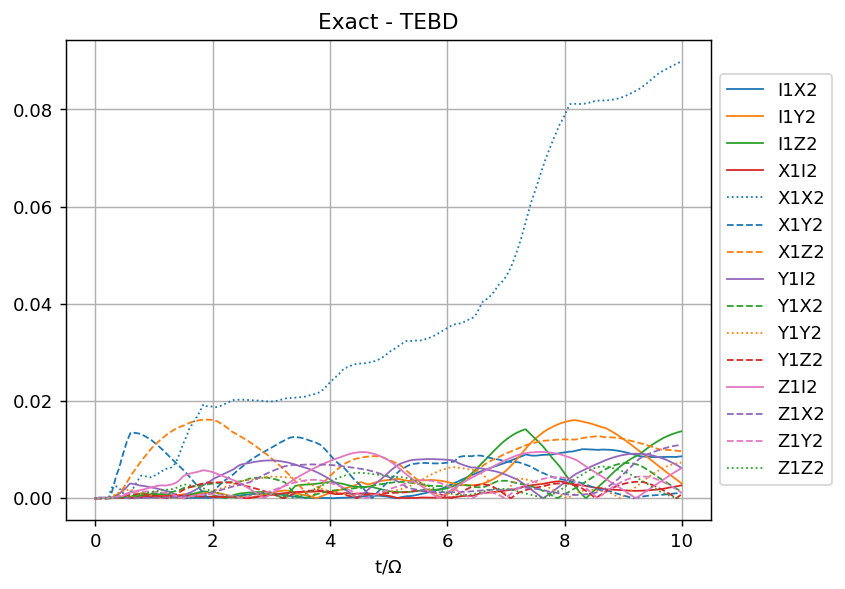

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5e-05, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7350.95%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:57<00:00, 17.41it/s]


Time:57s


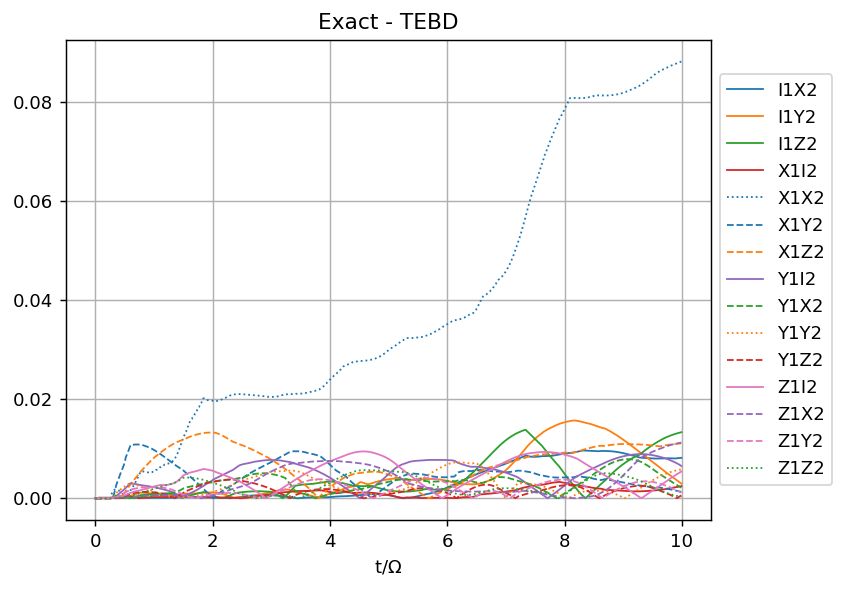

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5e-05, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4741.42%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [01:07<00:00, 14.74it/s]


Time:67s


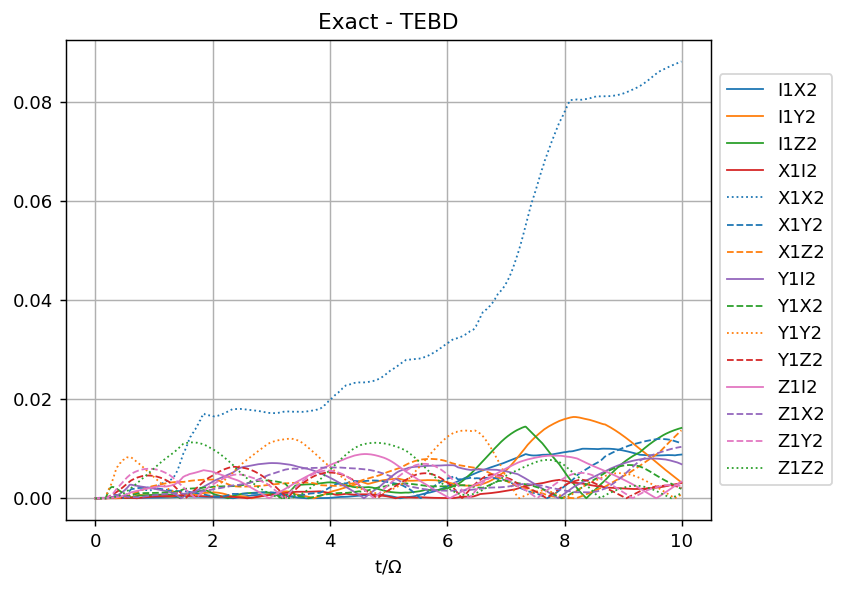

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.00025, max-bond=4: 100%|###############################################################################################################################################################################################| 100/100 [00:00<00:00, 6105.07%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:58<00:00, 17.00it/s]


Time:58s


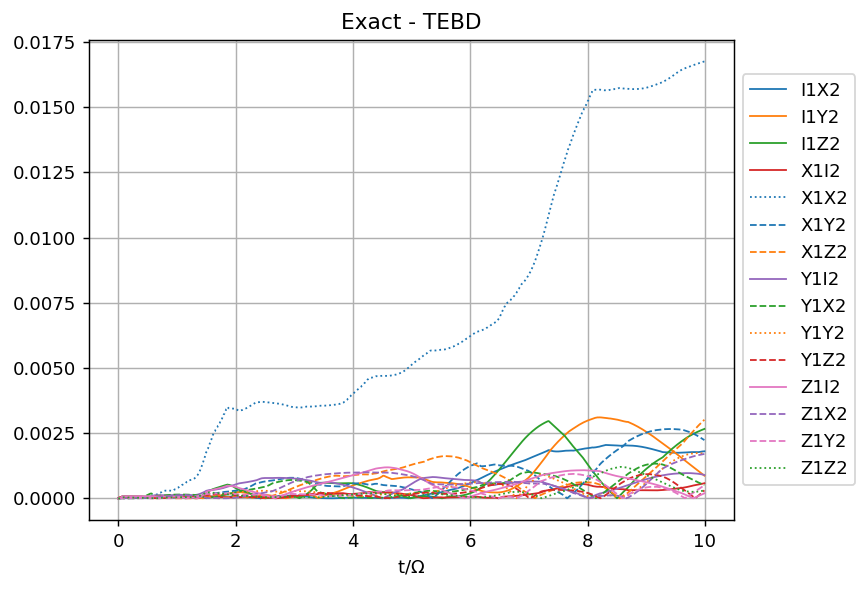

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.00025, max-bond=4: 100%|###############################################################################################################################################################################################| 100/100 [00:00<00:00, 7339.50%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:58<00:00, 17.13it/s]


Time:58s


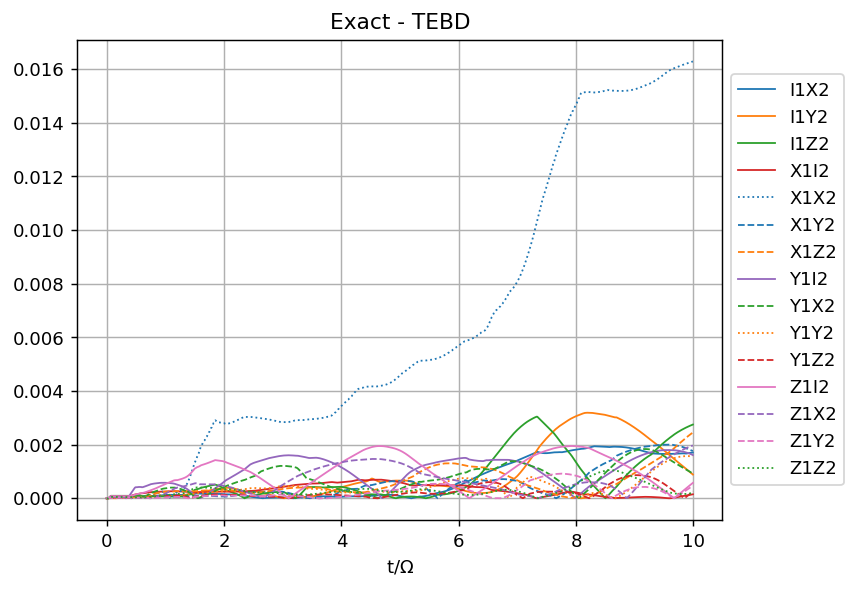

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.00025, max-bond=4: 100%|###############################################################################################################################################################################################| 100/100 [00:00<00:00, 7319.77%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [01:08<00:00, 14.68it/s]


Time:68s


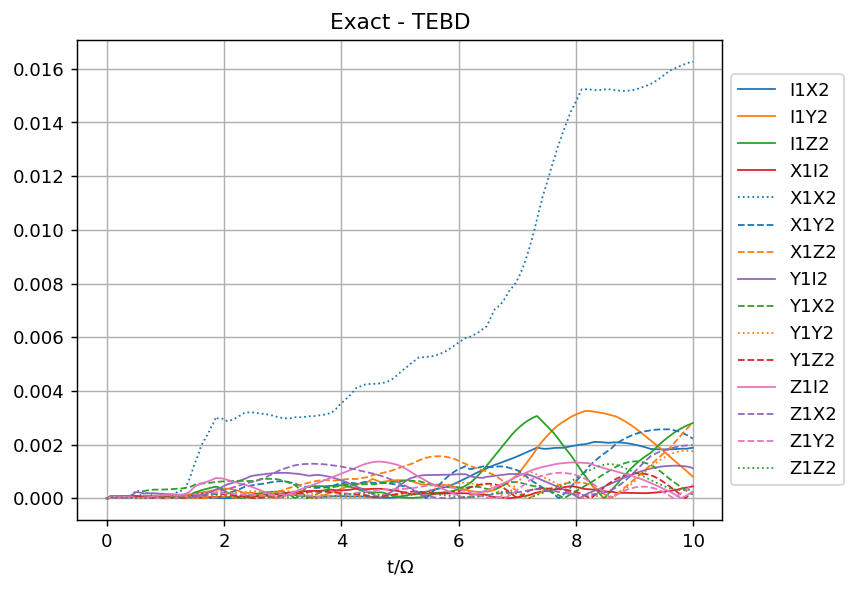

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.00025, max-bond=4: 100%|###############################################################################################################################################################################################| 100/100 [00:00<00:00, 7448.60%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:57<00:00, 17.46it/s]


Time:57s


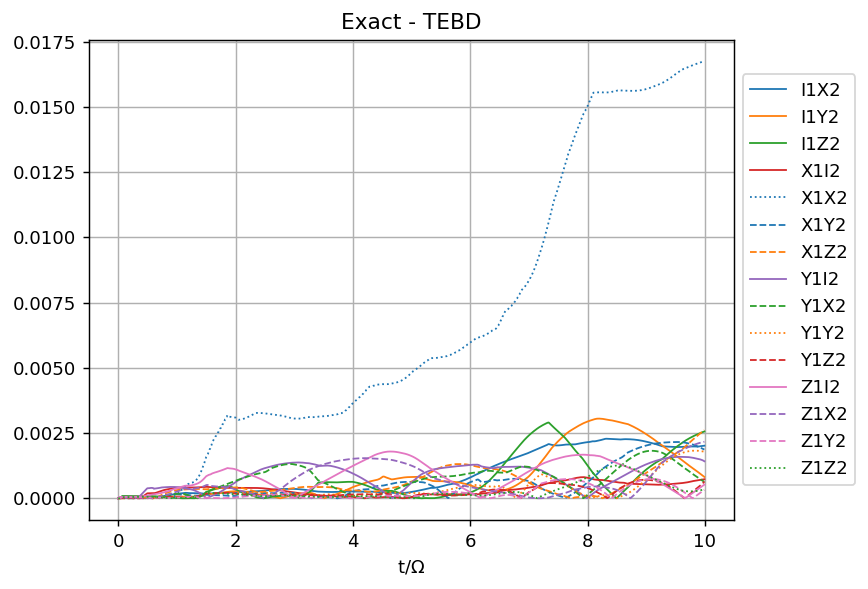

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.00025, max-bond=4: 100%|###############################################################################################################################################################################################| 100/100 [00:00<00:00, 7481.15%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:51<00:00, 19.54it/s]


Time:51s


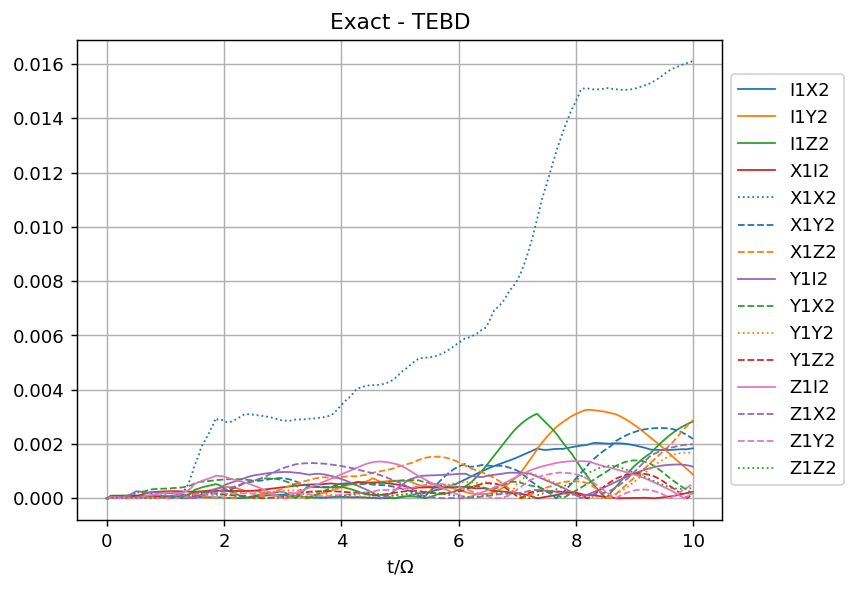

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 7325.66%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:41<00:00, 23.86it/s]


Time:41s


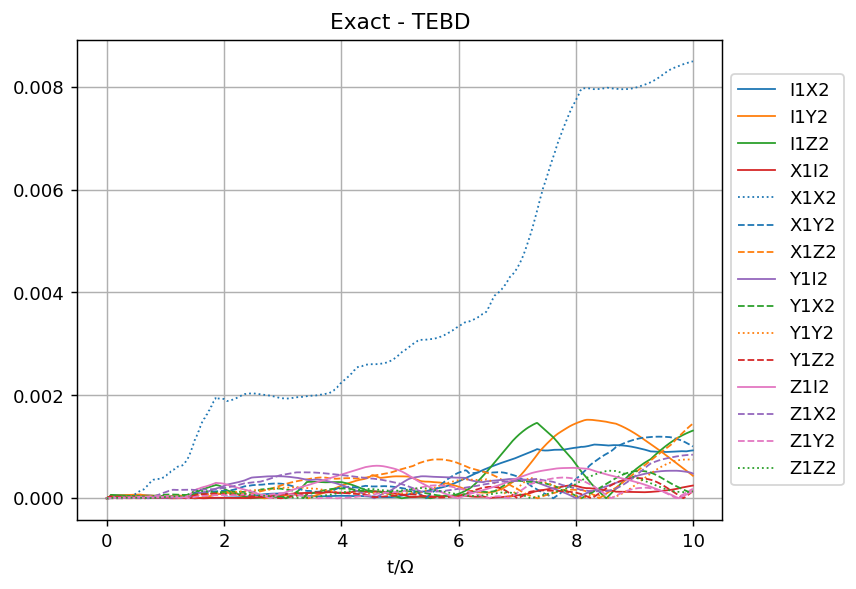

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8522.41%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:42<00:00, 23.72it/s]


Time:42s


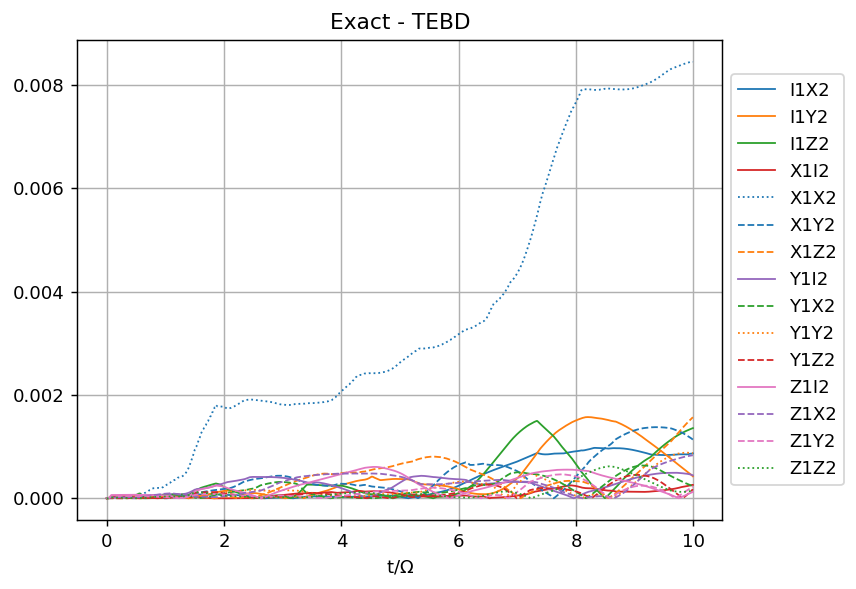

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8514.28%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.07it/s]


Time:34s


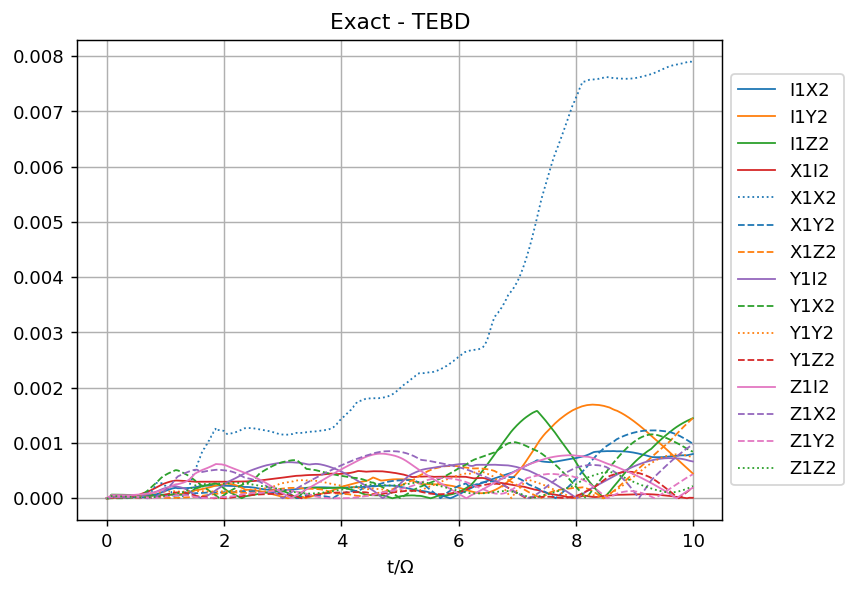

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8366.85%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:44<00:00, 22.45it/s]


Time:44s


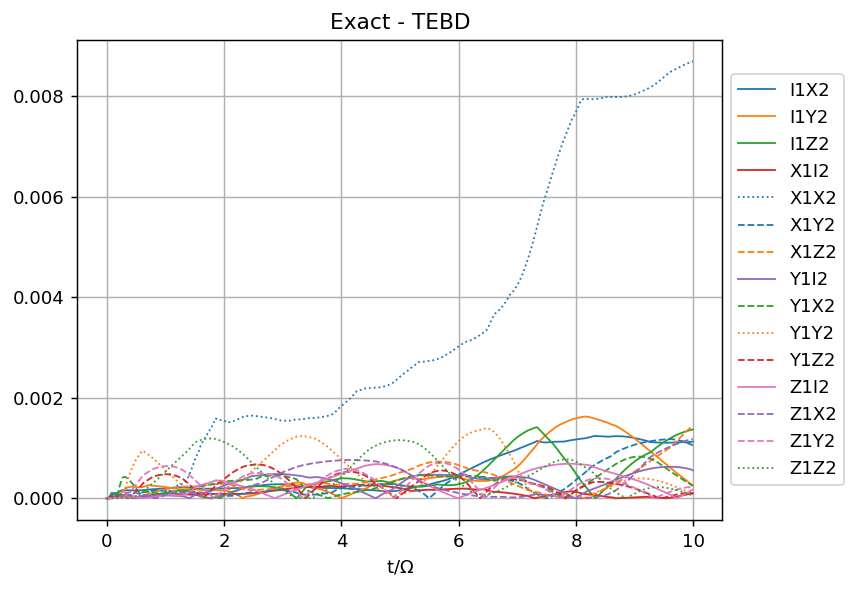

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 7592.46%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:36<00:00, 27.29it/s]


Time:36s


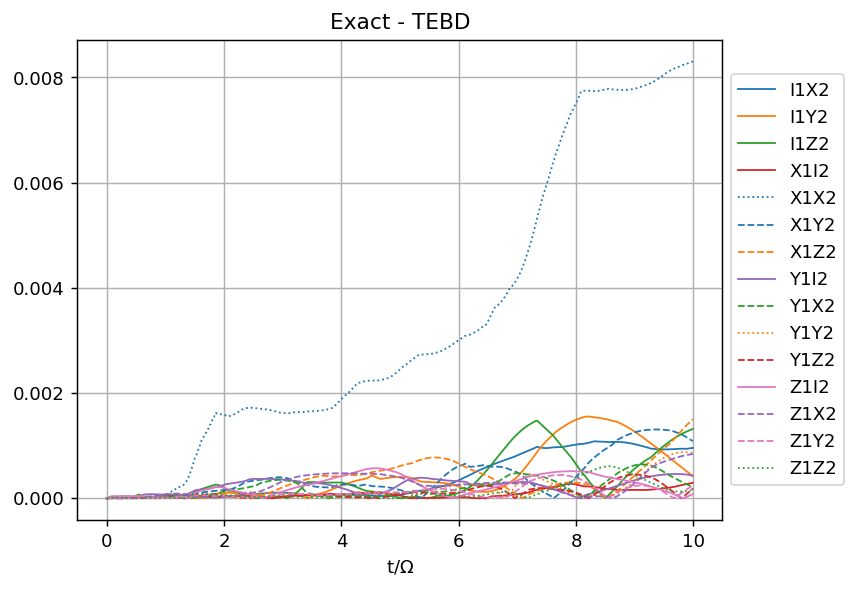

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0025, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8291.76%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.78it/s]


Time:34s


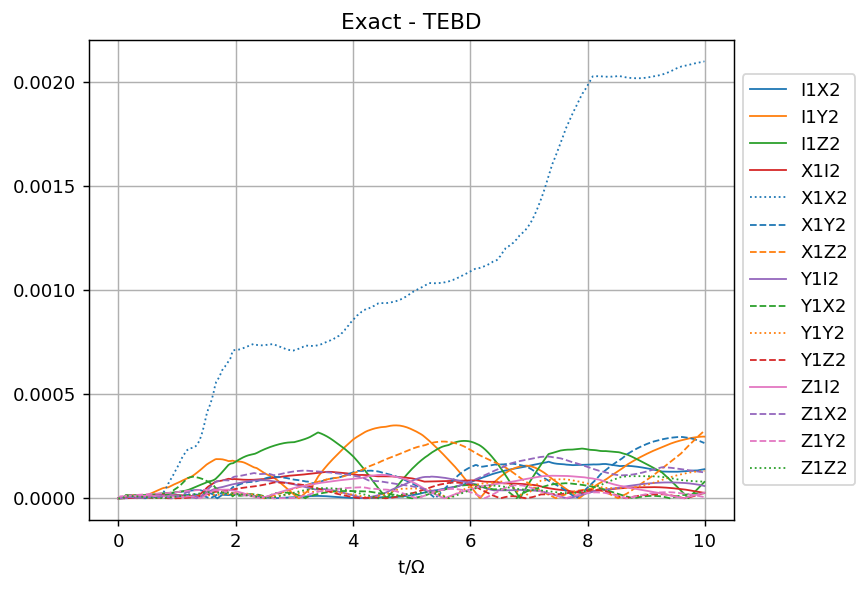

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0025, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8473.51%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.78it/s]


Time:34s


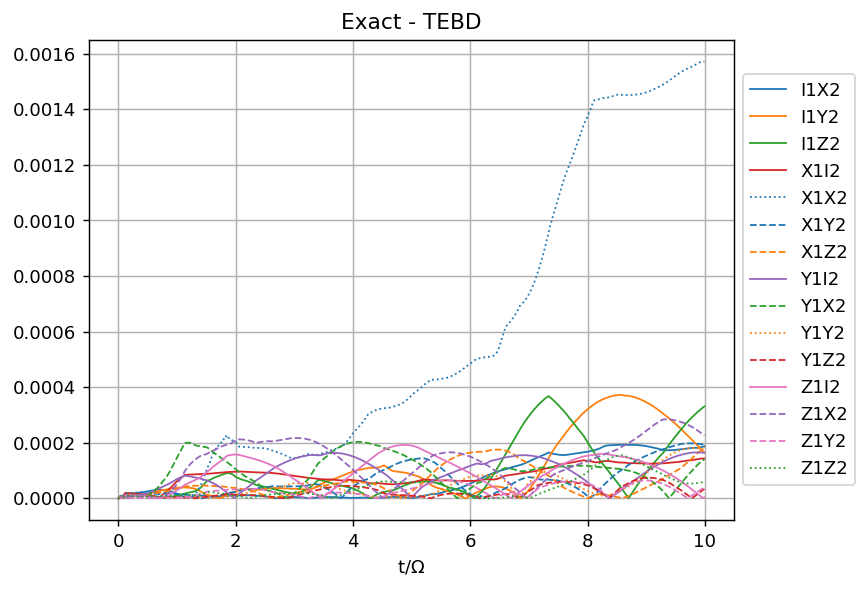

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0025, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8434.83%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.94it/s]


Time:34s


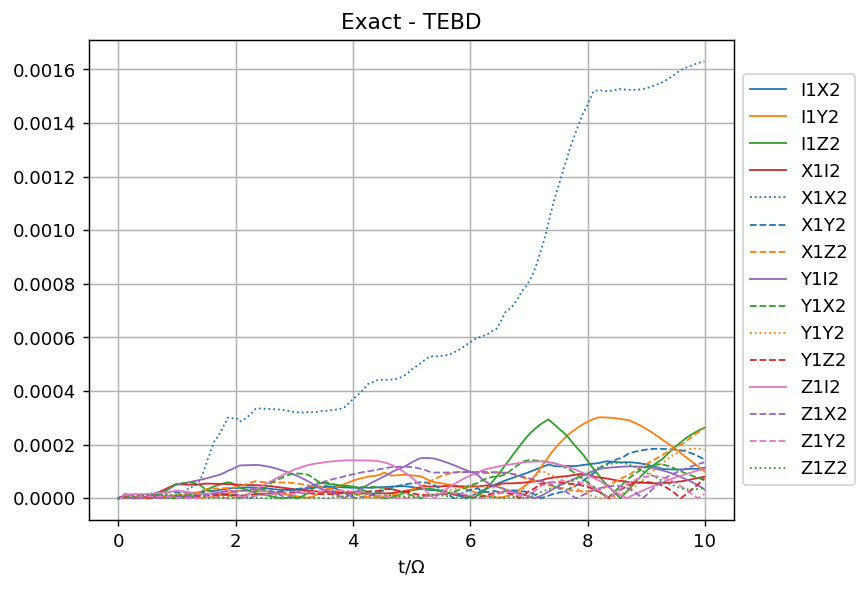

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0025, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8436.70%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.06it/s]


Time:34s


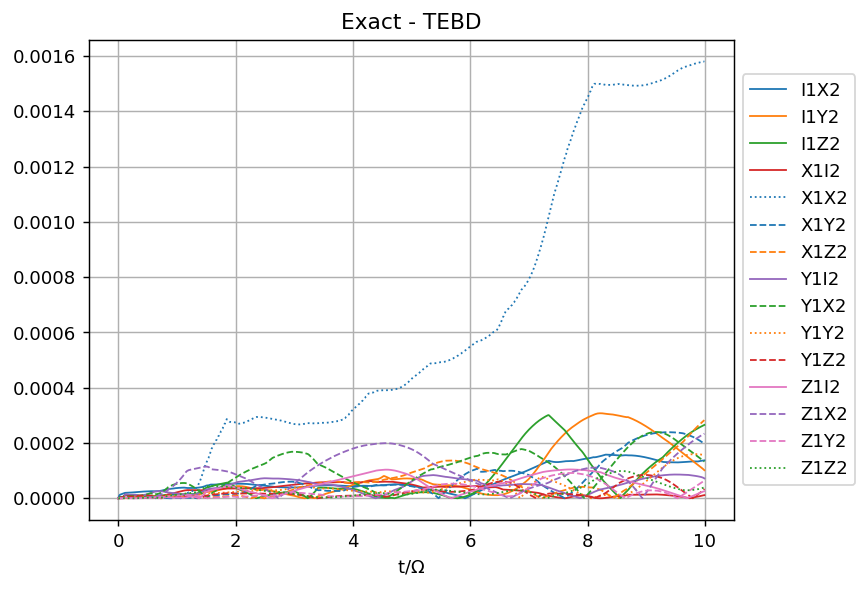

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.0025, max-bond=4: 100%|################################################################################################################################################################################################| 100/100 [00:00<00:00, 8588.90%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.06it/s]


Time:34s


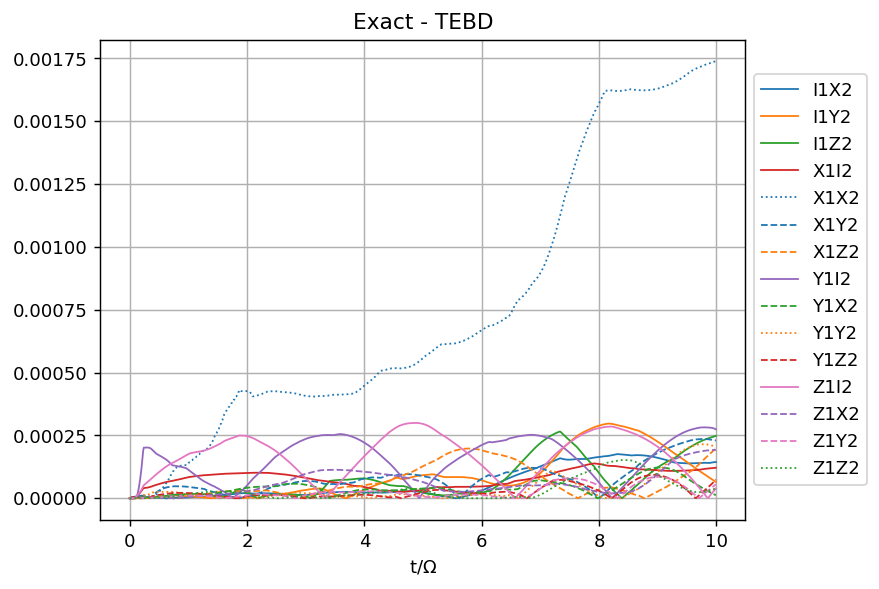

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8465.99%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.89it/s]


Time:34s


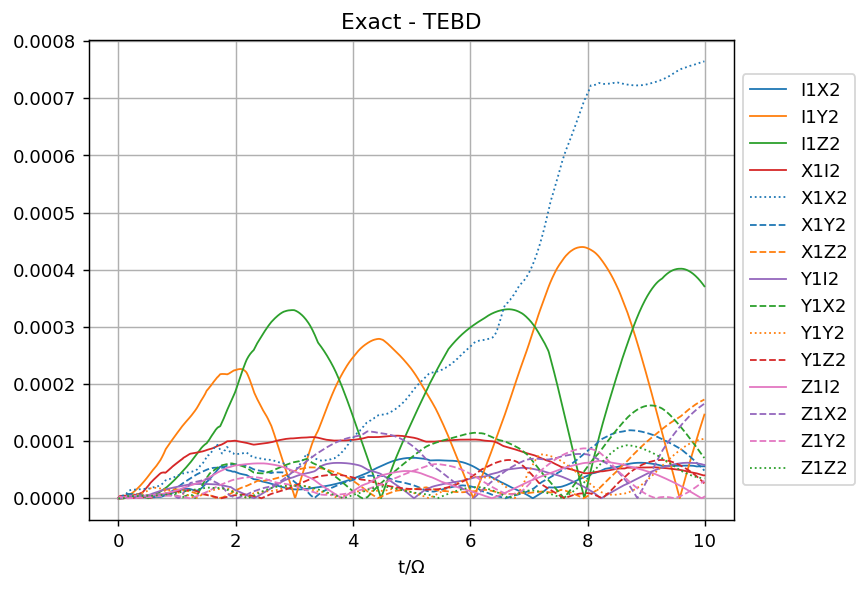

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8399.70%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.06it/s]


Time:34s


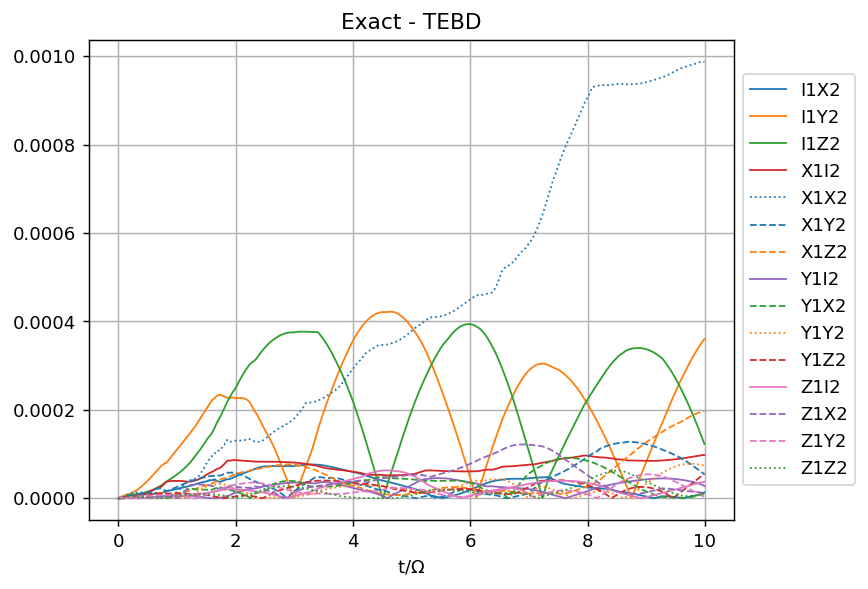

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8507.54%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.19it/s]


Time:34s


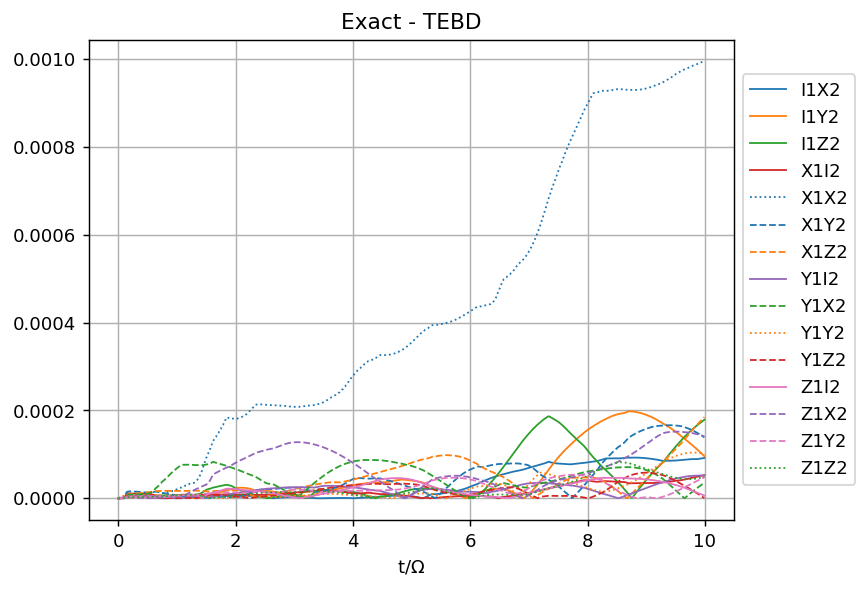

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8421.96%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.11it/s]


Time:34s


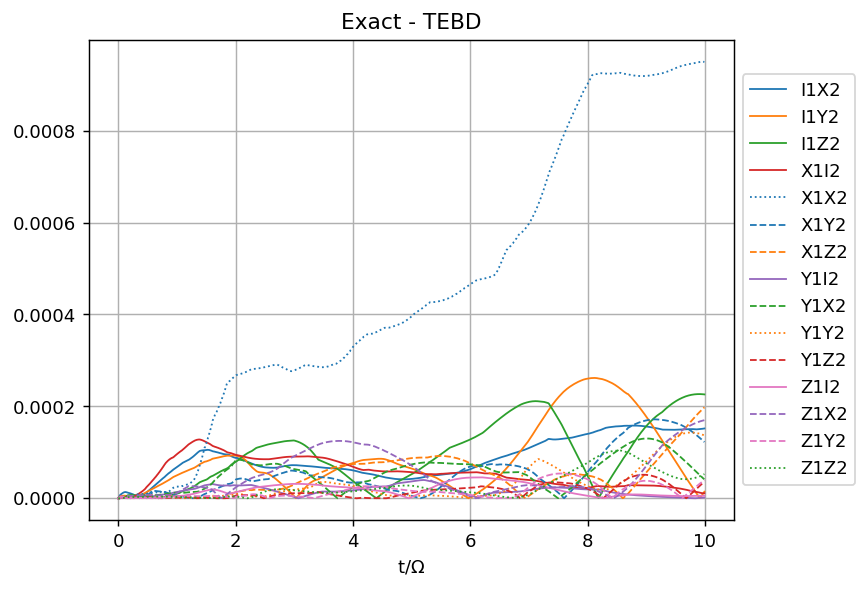

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8393.14%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.08it/s]


Time:34s


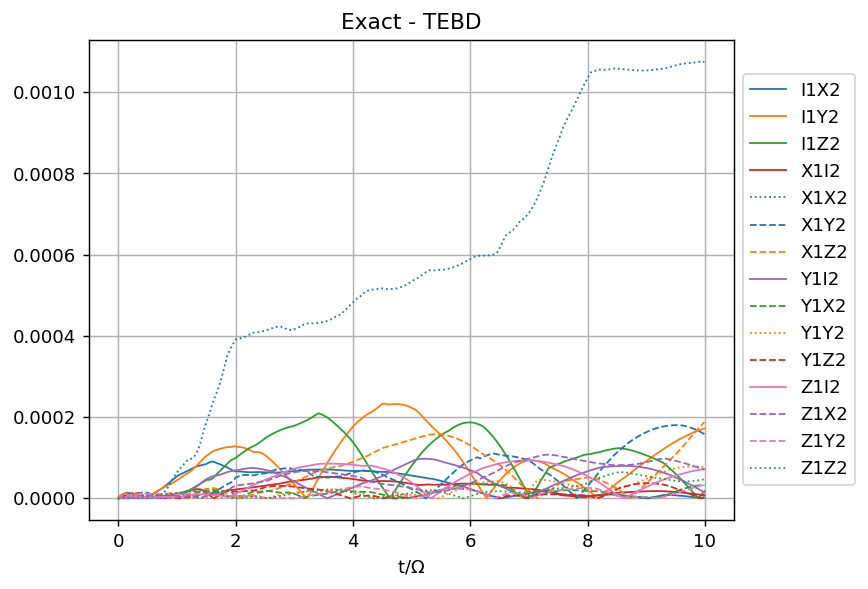

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8035.99%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.17it/s]


Time:34s


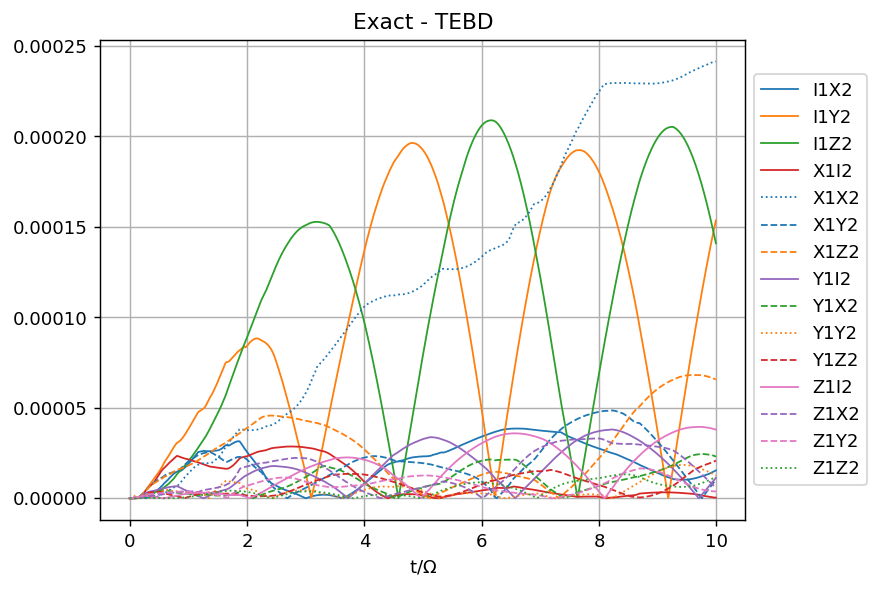

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8090.24%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.09it/s]


Time:34s


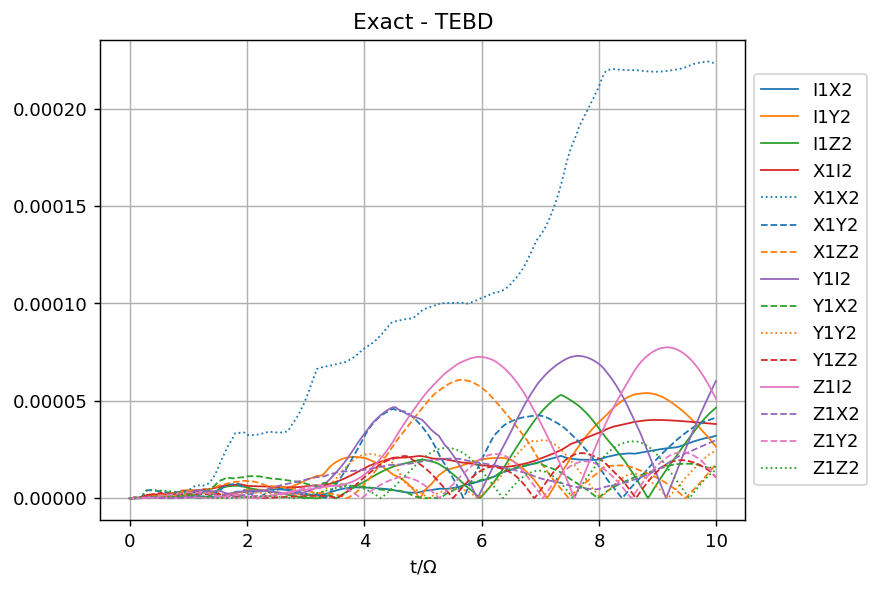

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8228.00%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.73it/s]


Time:34s


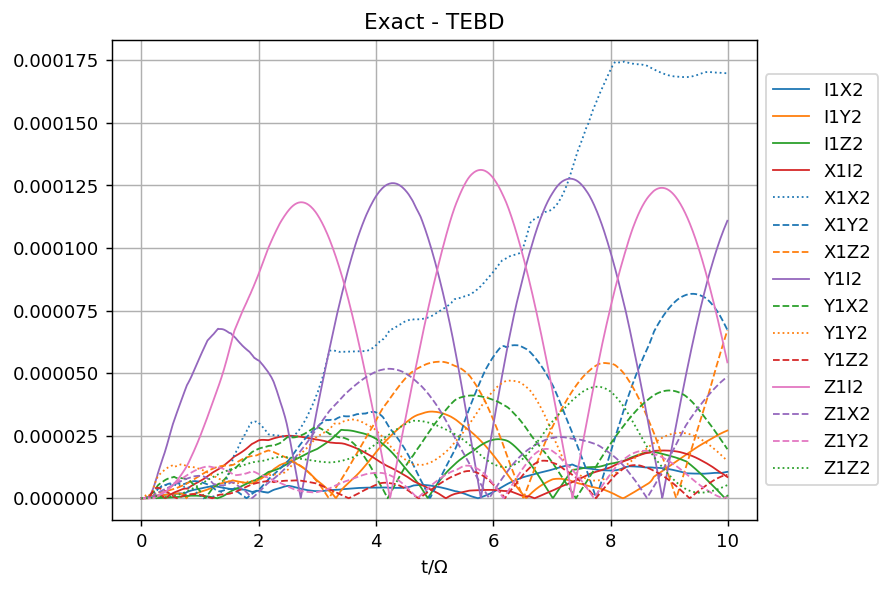

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8086.96%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.89it/s]


Time:34s


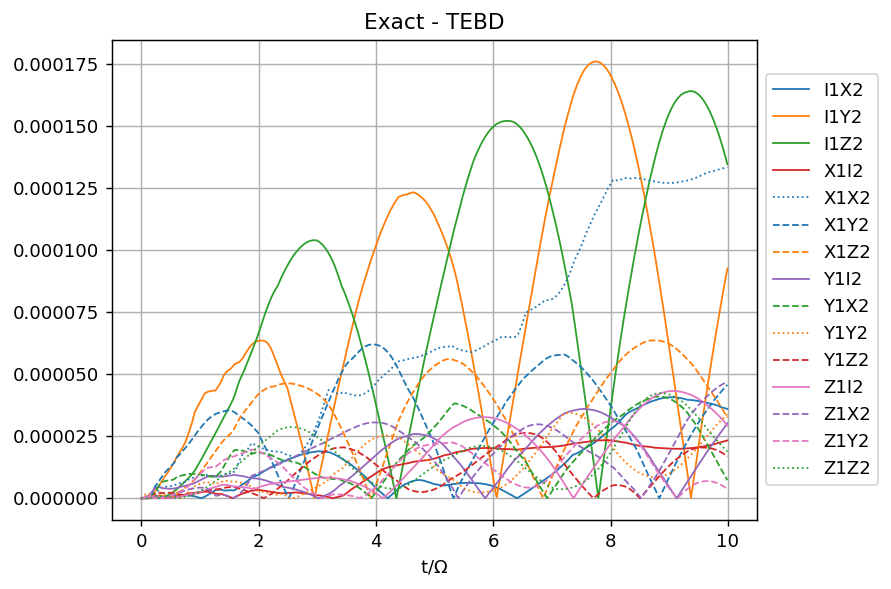

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 8064.42%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.91it/s]


Time:34s


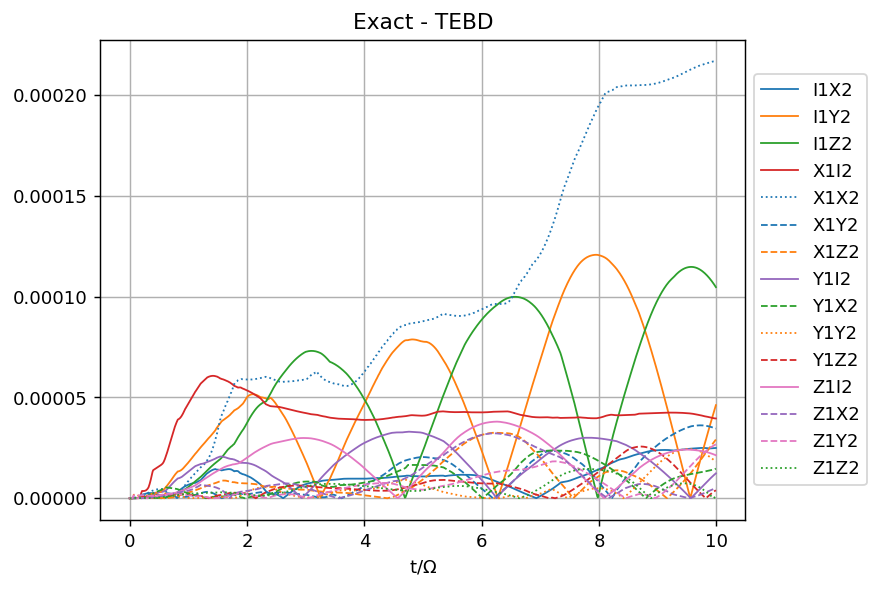

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=5: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 8050.02%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.74it/s]


Time:34s


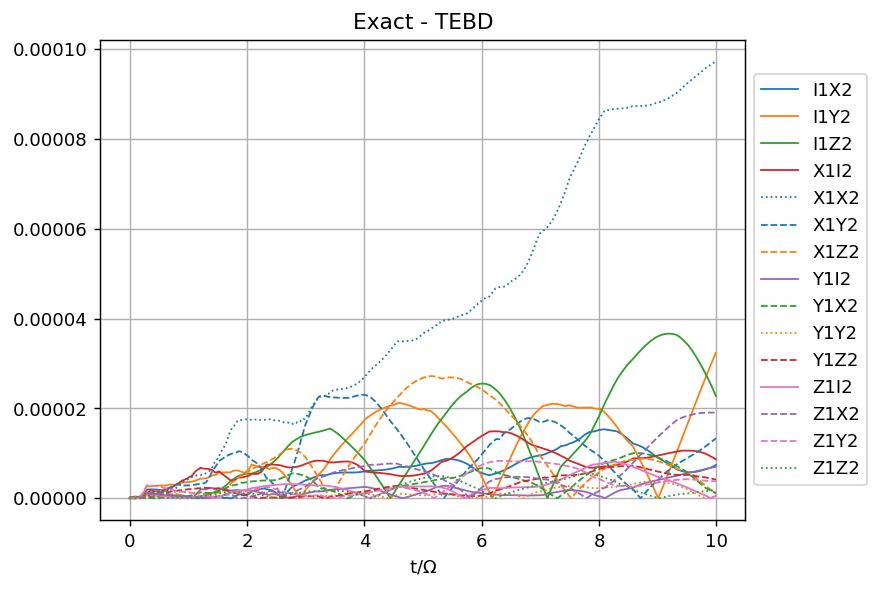

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=5: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 7989.00%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.04it/s]


Time:34s


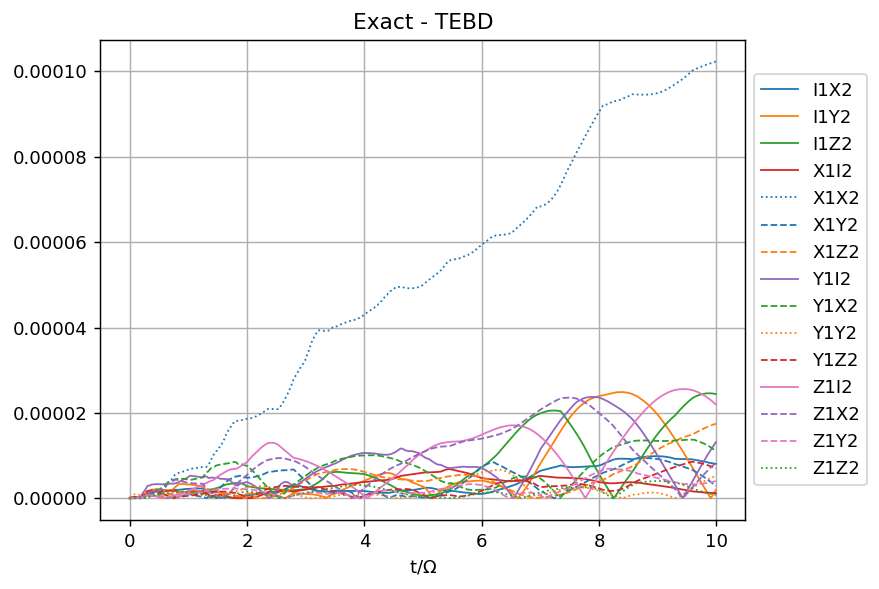

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=5: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 7833.96%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.02it/s]


Time:34s


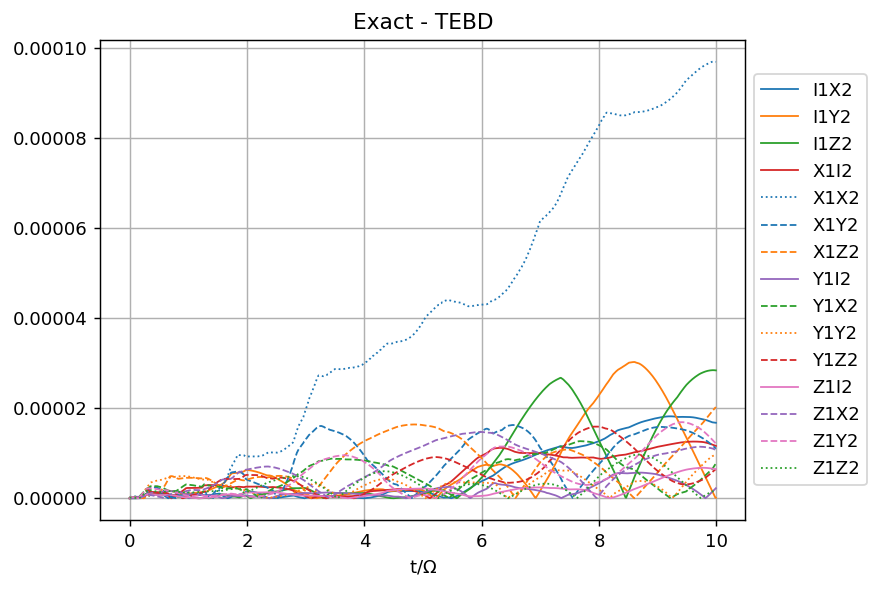

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=5: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 8207.23%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.18it/s]


Time:34s


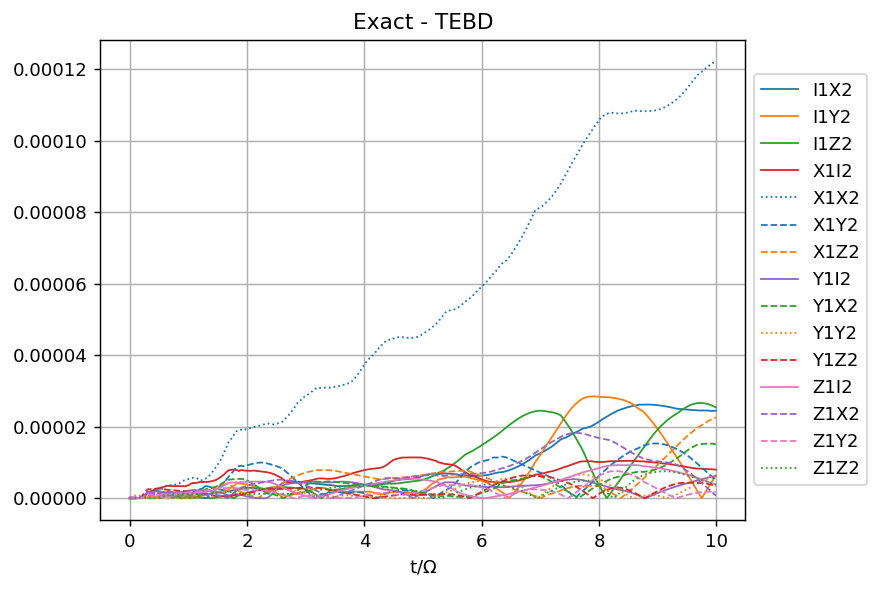

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.05, max-bond=5: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 8046.32%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.24it/s]


Time:34s


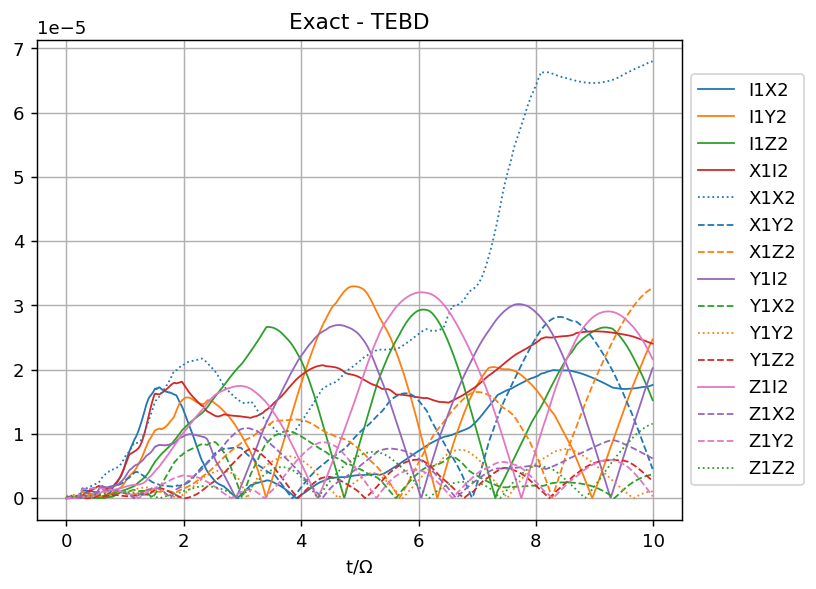

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.25, max-bond=6: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4236.03%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.99it/s]


Time:34s


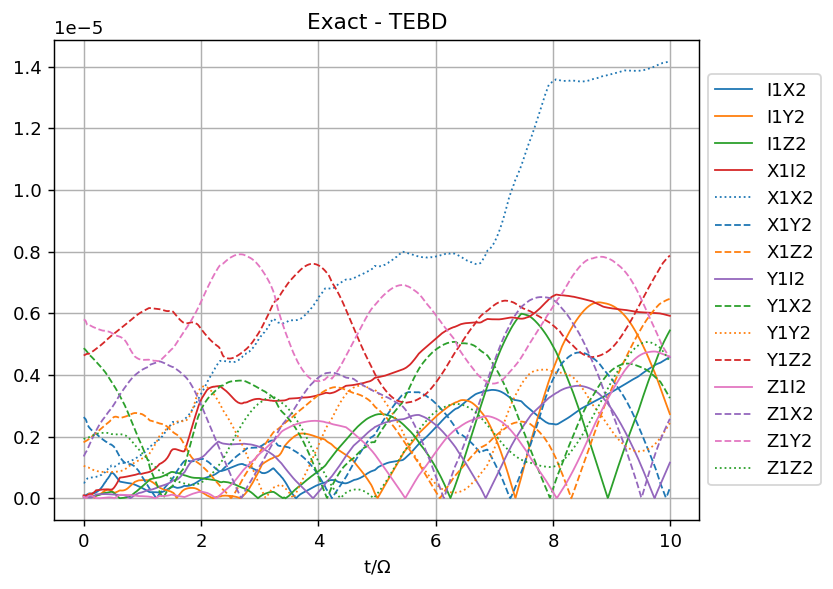

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.25, max-bond=6: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4236.20%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.95it/s]


Time:34s


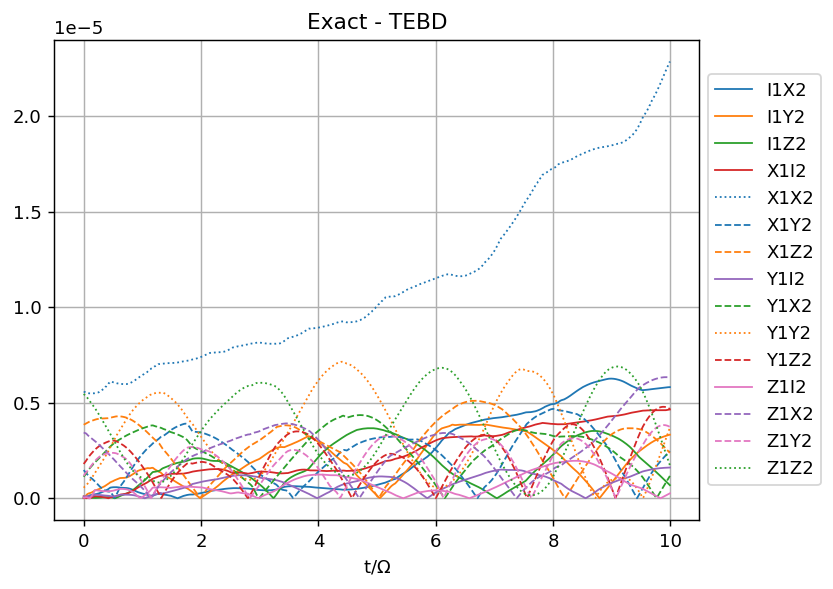

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.25, max-bond=6: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4269.84%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.83it/s]


Time:34s


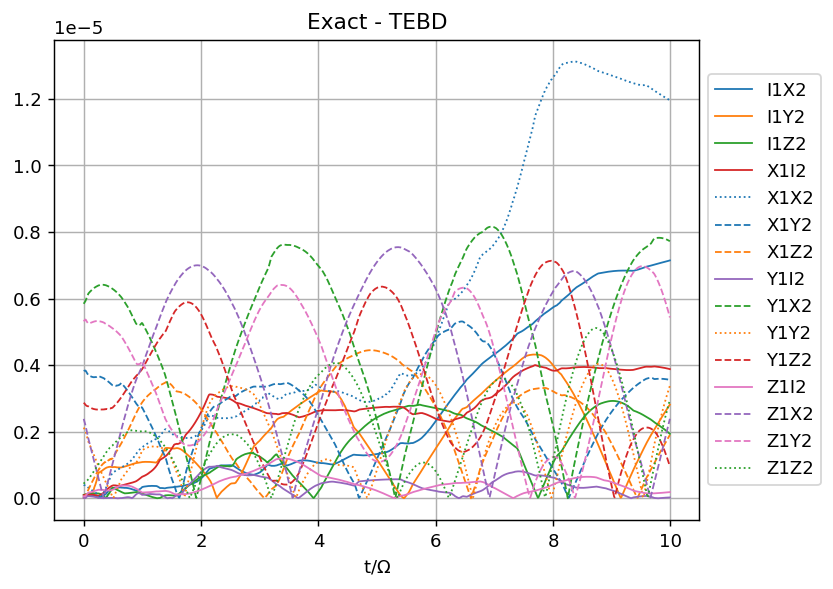

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.25, max-bond=6: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4335.91%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.85it/s]


Time:34s


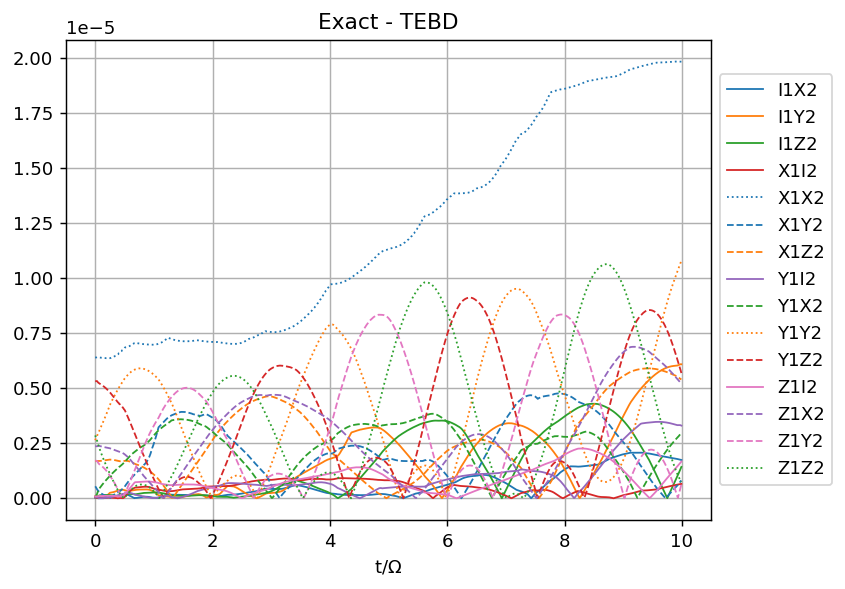

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.25, max-bond=6: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4165.73%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.64it/s]


Time:34s


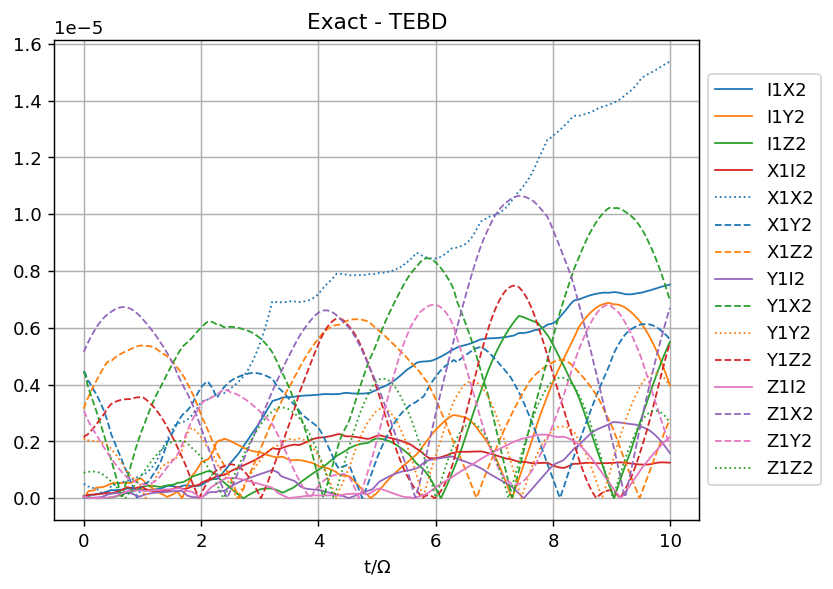

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=9: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 2886.41%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.65it/s]


Time:34s


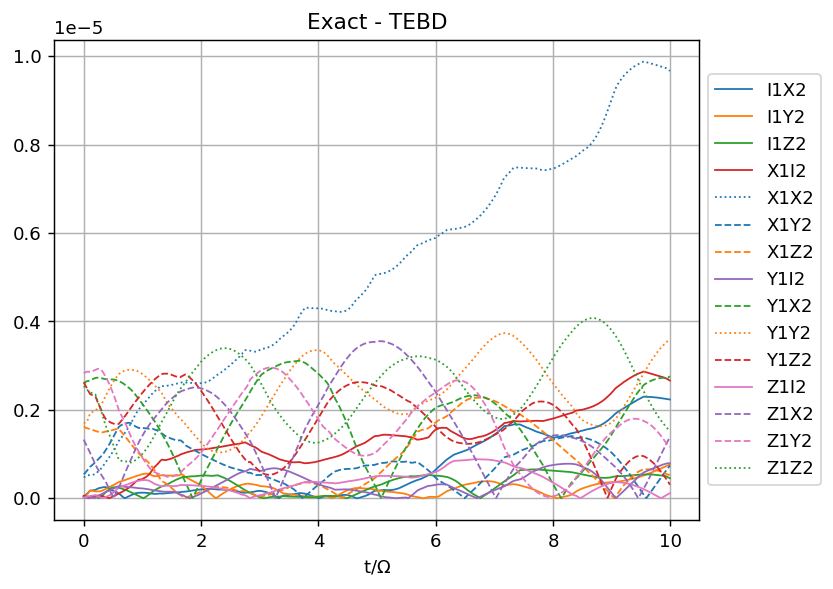

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=9: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 2921.09%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.61it/s]


Time:34s


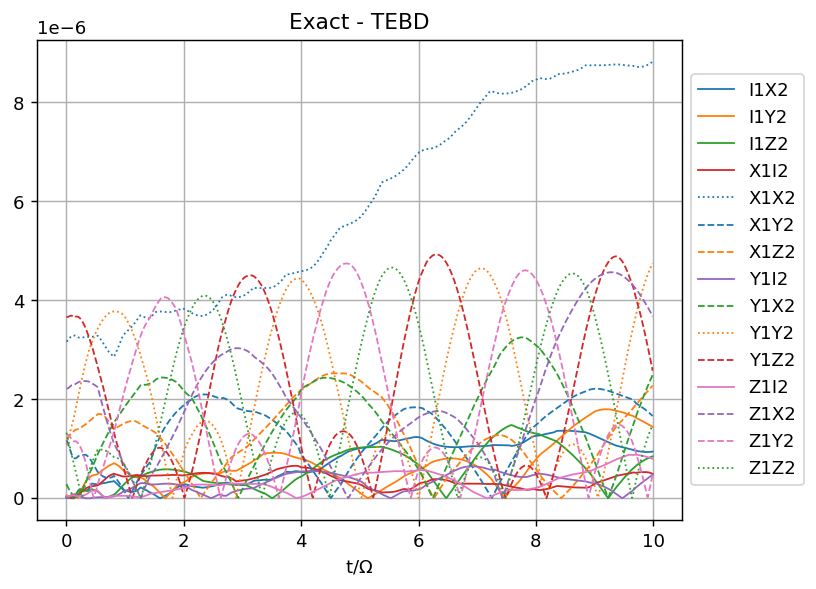

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=9: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 2944.47%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.96it/s]


Time:34s


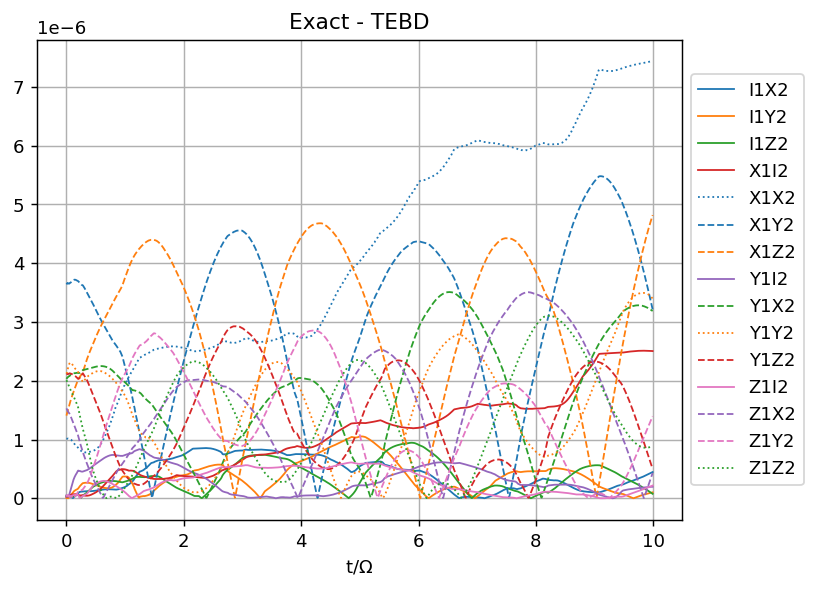

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=9: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 2915.16%/s]


Real time evolution


t=9.99, max-bond=24: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.72it/s]


Time:34s


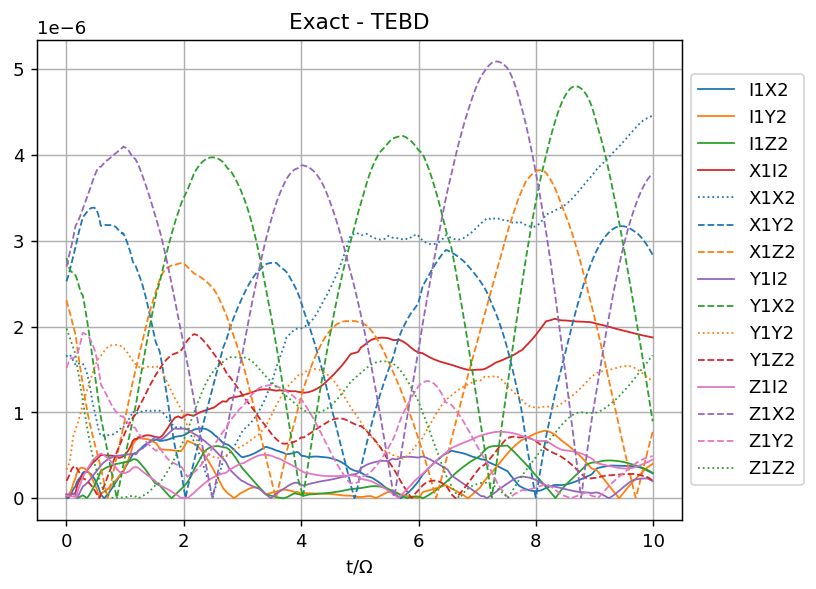

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=0.5, max-bond=9: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 2904.80%/s]


Real time evolution


t=9.99, max-bond=25: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 29.16it/s]


Time:34s


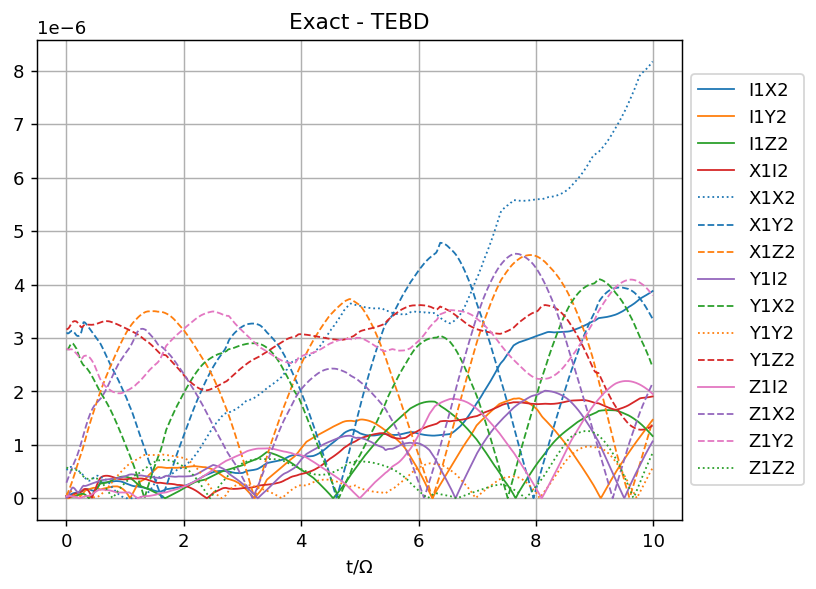

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=2.5, max-bond=17: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 370.95%/s]


Real time evolution


t=9.99, max-bond=21: 100%|################################################################################################################################################################################################| 1000/1000 [00:32<00:00, 30.83it/s]


Time:32s


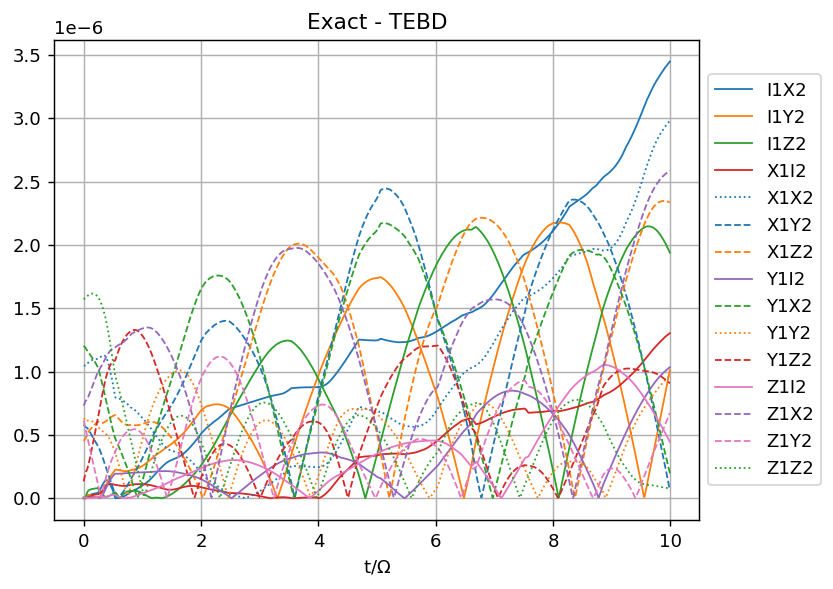

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=2.5, max-bond=17: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 404.50%/s]


Real time evolution


t=9.99, max-bond=22: 100%|################################################################################################################################################################################################| 1000/1000 [00:32<00:00, 30.99it/s]


Time:32s


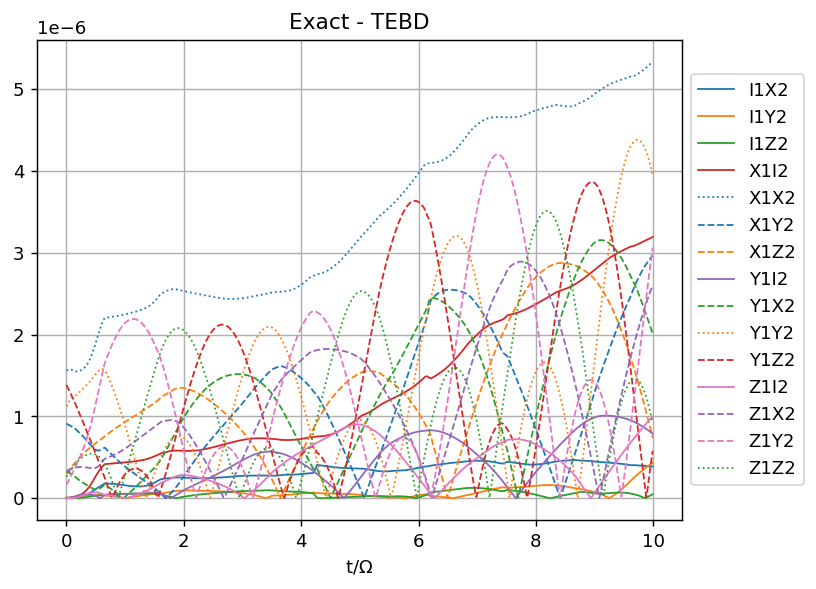

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=2.5, max-bond=17: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 401.89%/s]


Real time evolution


t=9.99, max-bond=21: 100%|################################################################################################################################################################################################| 1000/1000 [00:32<00:00, 31.14it/s]


Time:32s


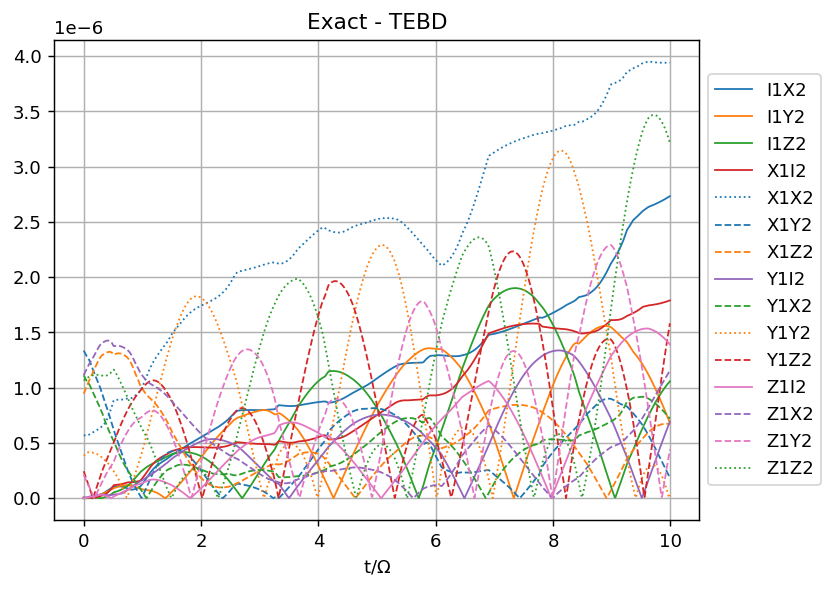

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=2.5, max-bond=17: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 408.44%/s]


Real time evolution


t=9.99, max-bond=21: 100%|################################################################################################################################################################################################| 1000/1000 [00:32<00:00, 30.95it/s]


Time:32s


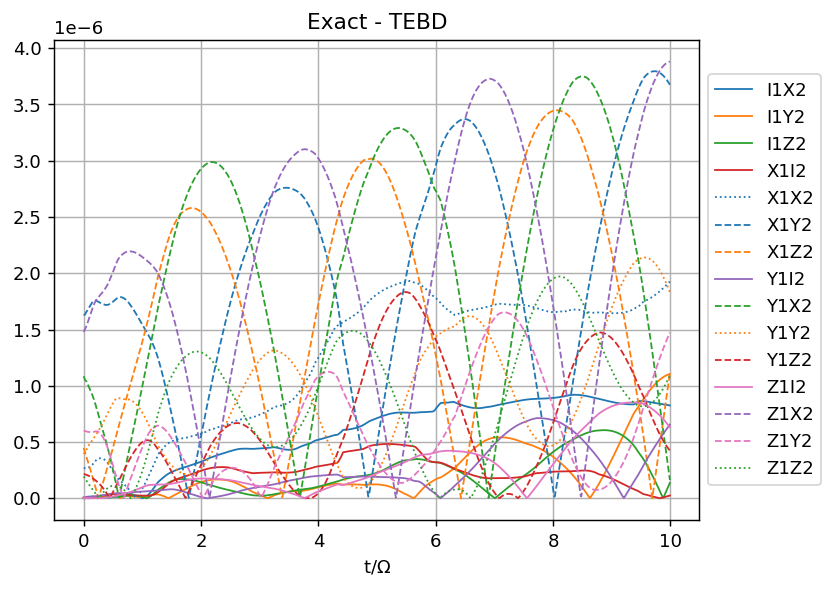

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=2.5, max-bond=17: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 403.79%/s]


Real time evolution


t=9.99, max-bond=21: 100%|################################################################################################################################################################################################| 1000/1000 [00:32<00:00, 31.09it/s]


Time:32s


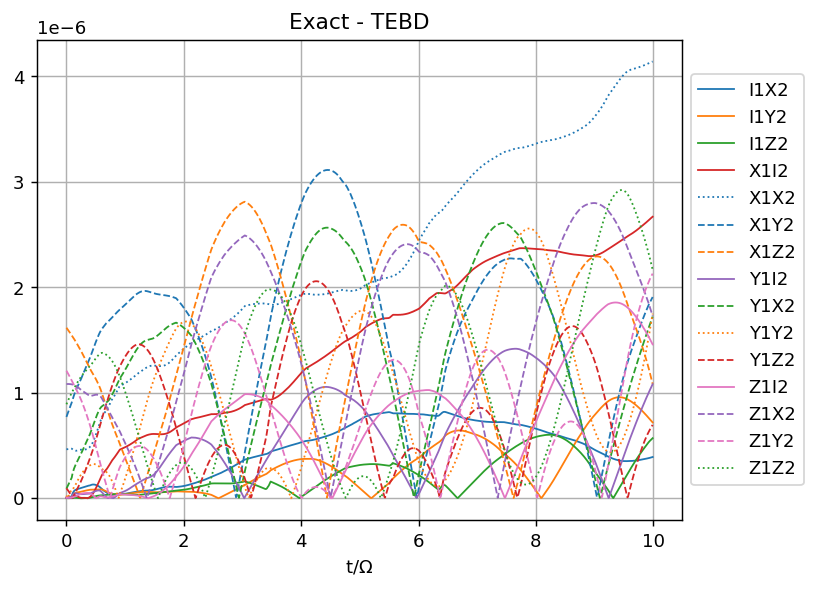

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5, max-bond=21: 100%|#####################################################################################################################################################################################################| 100/100 [00:00<00:00, 148.96%/s]


Real time evolution


t=9.99, max-bond=20: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.79it/s]


Time:34s


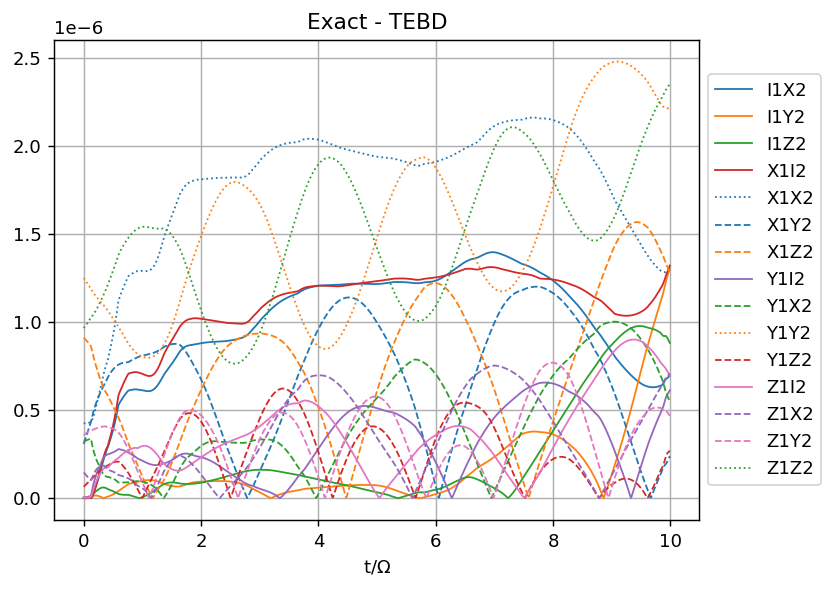

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5, max-bond=21: 100%|#####################################################################################################################################################################################################| 100/100 [00:00<00:00, 148.74%/s]


Real time evolution


t=9.99, max-bond=18: 100%|################################################################################################################################################################################################| 1000/1000 [00:35<00:00, 28.32it/s]


Time:35s


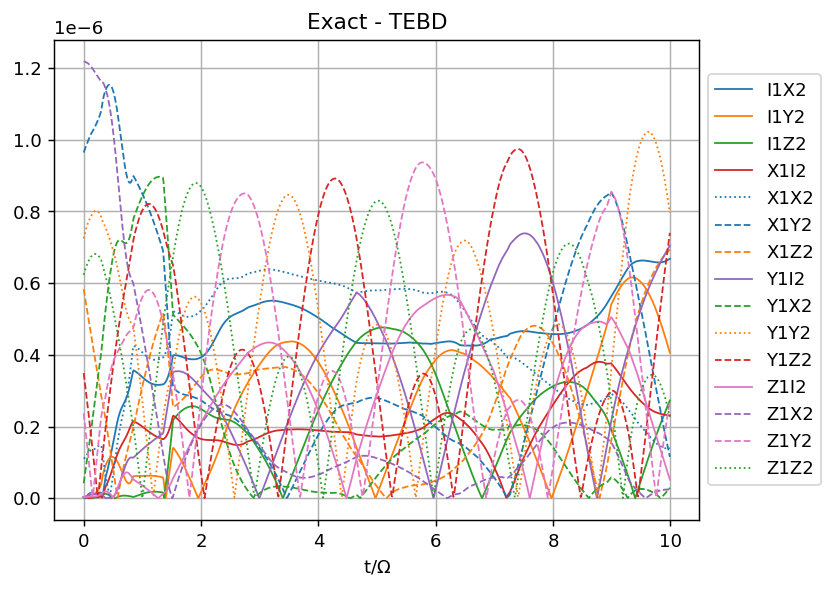

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5, max-bond=21: 100%|#####################################################################################################################################################################################################| 100/100 [00:00<00:00, 147.11%/s]


Real time evolution


t=9.99, max-bond=18: 100%|################################################################################################################################################################################################| 1000/1000 [00:34<00:00, 28.68it/s]


Time:34s


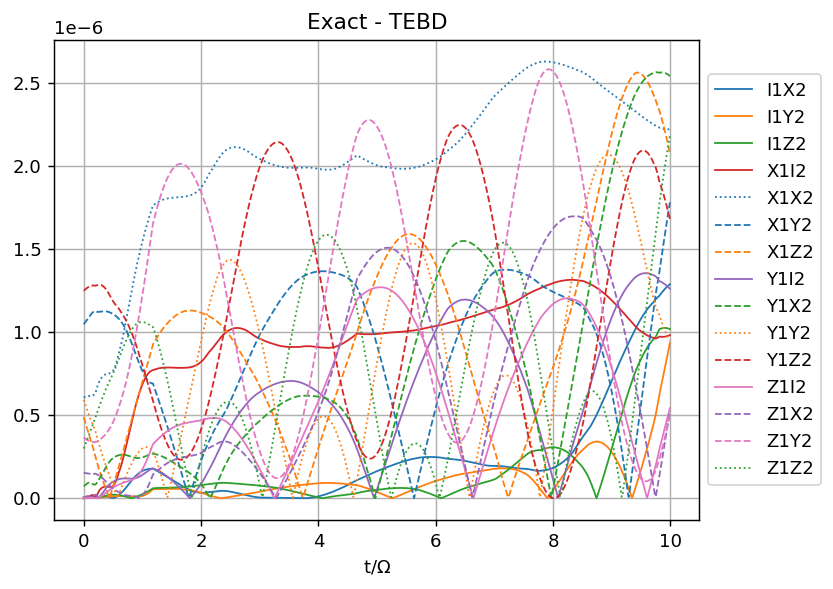

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5, max-bond=21: 100%|#####################################################################################################################################################################################################| 100/100 [00:00<00:00, 147.30%/s]


Real time evolution


t=9.99, max-bond=20: 100%|################################################################################################################################################################################################| 1000/1000 [00:35<00:00, 27.94it/s]


Time:35s


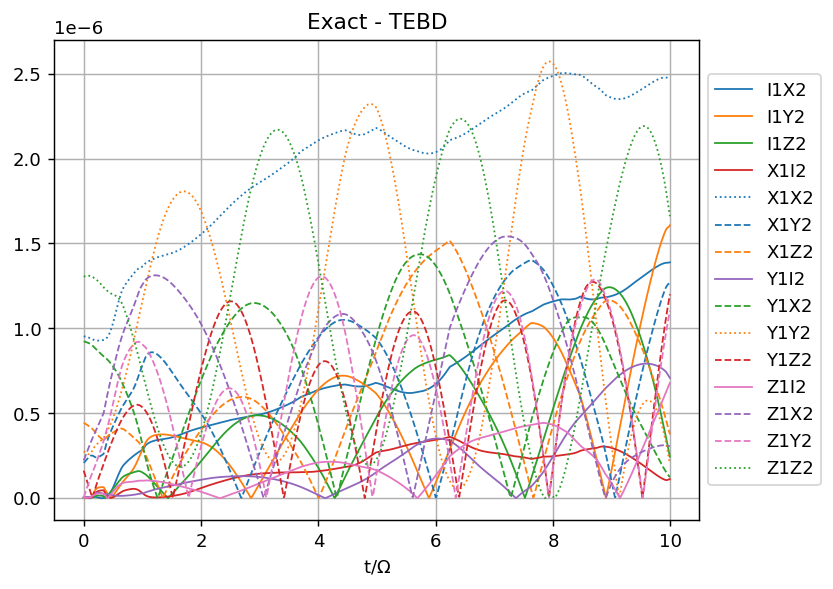

Building Hamiltonian for L=6
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=6 

Building the spin chain 

Imaginary time evolution 



t=5, max-bond=21: 100%|#####################################################################################################################################################################################################| 100/100 [00:00<00:00, 147.55%/s]


Real time evolution


t=9.99, max-bond=19: 100%|################################################################################################################################################################################################| 1000/1000 [00:35<00:00, 28.22it/s]


Time:35s


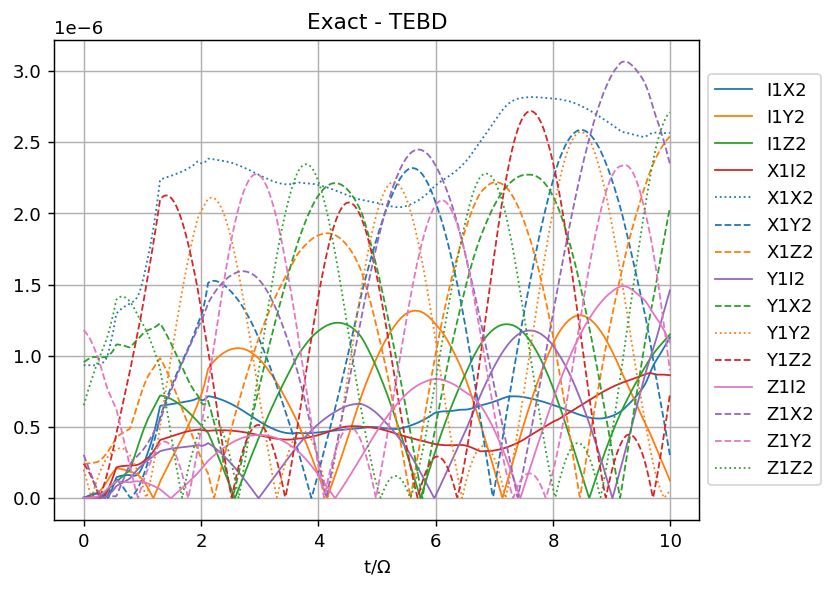

In [10]:
err = 0
errore = {}
betas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
for beta in betas:
    err = 0
    for i in range(5):
        err += calculate_error(L=6, omega=1, V=0.1, V_=0.1, beta=beta, T=10, \
                               dt=0.01, re_cutoff=1e-8, img_cutoff=1e-10, tolerance=1e-3)
    errore[str(beta)] = err/5

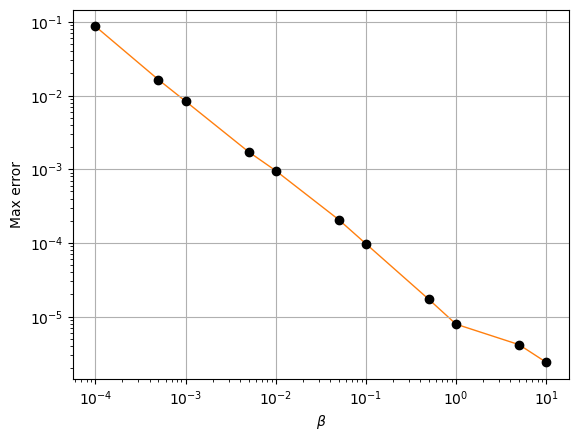

In [27]:
plt.figure(dpi=100)

x = [errore[str(beta)] for beta in betas]

plt.scatter(betas, x, linewidth=1, color='black', zorder=2)
plt.plot(betas, x, linewidth=1, color='tab:orange', zorder=1)

plt.grid()
plt.xlabel(r'$\beta$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Max error')

fig = plt.gcf()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()